In [438]:
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi
import numpy as np
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score
import geopandas
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data import *
pd.set_option('display.max_columns',None)

### Load the necessary data

In [439]:
dist_path ='../data/shapefiles/tanzania_districts/Districts.shx'
feature_path = "../data/training_set_values.csv"
label_path = "../data/training_set_labels.csv"
y_pred_path = "best_y_preds_test.csv"
districts = geopandas.read_file(dist_path)
features = pd.read_csv(feature_path)
label = pd.read_csv(label_path).rename(columns = {'status_group':'y_true'})
y_preds = pd.read_csv(y_pred_path).rename(columns = {'status_group':'y_pred'})

### Create dataframe of true and predicted labels for each well

In [440]:
df_acc = pd.merge(features[['id','lga','population']],label, on = 'id')
df_acc = pd.merge(df_acc, y_preds, on = 'id')
df_acc.replace(to_replace = ['functional','functional needs repair','non functional'],
               value = [2,1,0],inplace = True)

### Group data by region and calculate score for each region

In [441]:
df_grouped = df_acc.sort_values(by = 'lga', axis = 0).groupby('lga').count().reset_index()[['lga','id']]
recall_scores = []
accuracy_scores = []
precision_scores = []
f1_scores = []
for district in df_grouped['lga']:
    dist_df = df_acc[df_acc['lga'] == district]
    accuracy_scores.append(round(accuracy_score(dist_df['y_true'], dist_df['y_pred']),2))
    recall_scores.append(round(well_recall(dist_df['y_true'], dist_df['y_pred']),2))
    precision_scores.append(round(precision_score(dist_df['y_true'], dist_df['y_pred'],average = None)[0],2))
    f1_scores.append(round(f1_score(dist_df['y_true'], dist_df['y_pred'],average = None)[0],2))
df_grouped['recall_score'] = recall_scores
df_grouped['accuracy_score'] = accuracy_scores
df_grouped['precision_score'] = precision_scores
df_grouped['f1_score'] = f1_scores

In [442]:
df_pops = df_acc.sort_values(by = 'lga', axis = 0).groupby('lga').sum()[['population']]

### Clean up district names so district names in geodata and scoring dataframes so names match and merging is successful

In [443]:
df_grouped['lga'] = df_grouped['lga'].str.replace(' Rural','')
districts.loc[districts['District_N'] == 'Kigoma  Urban', 'District_N'] = 'Kigoma Urban'
districts.loc[districts['District_N'] == 'Misungwi', 'District_N'] = 'Missungwi'
districts.loc[districts['District_N'] == 'Tanga Urban', 'District_N'] = 'Tanga'
districts.loc[districts['District_N'] == 'Missenyi', 'District_N'] = 'Misenyi'

### Merge scoring dataframe and geodata dataframe to prepare for cholopleth mapping

In [444]:
df_geo = pd.merge(df_grouped, districts, 
                  how = 'right', 
                  left_on = 'lga', 
                  right_on = 'District_N').drop(columns = ['District_C','District_N'])
df_geo = geopandas.GeoDataFrame(df_geo)

### Create dataframe of non-functional well locations for mapping markers

In [445]:
wells_nonfunc = pd.merge(features,label, on = 'id')
wells_nonfunc.loc[wells['longitude'] == 0, 'longitude'] = np.nan
wells_nonfunc = geopandas.GeoDataFrame(wells[['latitude','longitude','y_true']],
                               geometry = geopandas.points_from_xy(wells.longitude, wells.latitude))
wells_nonfunc = wells.set_crs(epsg = 4210)
wells_nonfunc = wells[wells['y_true'] == 'non functional']

### In which regions are we most accurately predicting failed wells?  About how many wells are in those regions?

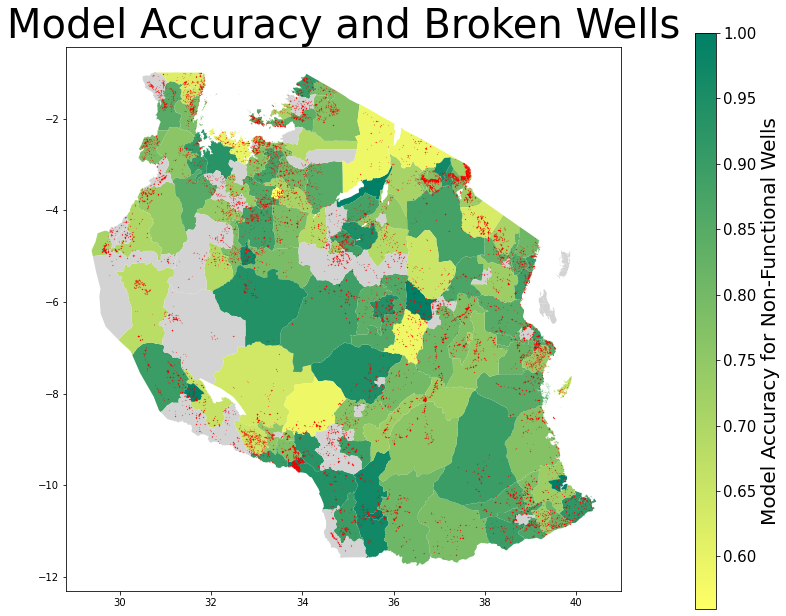

In [446]:
fig, ax = plt.subplots(figsize = (10,10))
cmap='summer_r'

df_geo.plot(ax = ax,
           column = 'accuracy_score',
           legend = False,
           cmap = cmap,
           missing_kwds = {'color':'lightgrey'} #Breaks the map if no NaNs
           )

ax.set_title('Model Accuracy and Broken Wells', fontsize = 40, y=.8)
vmin = df_geo['accuracy_score'].min()
vmax = df_geo['accuracy_score'].max()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=15) 
cbr.set_label('Model Accuracy for Non-Functional Wells', fontsize = 20)

wells_nonfunc.plot(ax = ax, color = 'red', markersize = .01)

plt.savefig('figures/accuracy_map',bbox_inches = 'tight')
plt.show()

## Check which regions we are most accurate in (90% or better).

In [457]:
best_accuracy = df_geo.sort_values(by = 'f1_score', ascending = False).drop(columns = 'geometry').reset_index()
best_accuracy = best_accuracy.rename({'id':'number_of_wells'}, axis = 1).fillna(0)
best_accuracy['number_of_wells'] = best_accuracy['number_of_wells'].astype(int)
cols = ['lga','number_of_wells','f1_score','accuracy_score','recall_score','precision_score']
best_accuracy = best_accuracy[cols]
dfi.export(best_accuracy.head(40),'figures/best_accuracy_df.png')
best_accuracy.head(40)

,lga,number_of_wells,f1_score,accuracy_score,recall_score,precision_score
0,Kongwa,72,1.00,1.00,1.00,1.00
1,Karatu,64,1.00,1.00,1.00,1.00
2,Lindi Urban,5,1.00,1.00,1.00,1.00
3,Mtwara Urban,25,1.00,0.92,1.00,1.00
4,Songea Urban,14,1.00,1.00,1.00,1.00
5,Arusha Urban,9,1.00,0.78,1.00,1.00
6,Sumbawanga Urban,30,1.00,1.00,1.00,1.00
7,Songea,158,1.00,0.97,1.00,1.00
8,Dodoma Urban,72,0.99,0.94,1.00,0.98
9,Chamwino,74,0.98,0.86,0.97,1.00
